In [10]:
import os
import load_nonneurals
nnfuncs = load_nonneurals.load_nneural_map(False)

# Step 1: Understanding French Orthography
### L'Académie Française
We have probably all encountered English writing style guides full of arbitrarily selected prescriptivist rules about what "correct" English is, and if one were to try and compile a master list of every prescriptivist rule written in one of these books, they would likely find a lot of contradictions.

France, on the other hand, has an actual, official governing body that is considered the final authority on what is and is not "correct" French. Their official mission, as written on their website (and translated by these authors) is as follows:
> The principal function of the Academy will be to work, with the greatest possible care and dilligence, on giving our language definite rules and to make it pure, eloquent, and capable of serving the arts and sciences.

They concisely sum it up at the top of the page as "the defense of the French language."

As such, although French is a natural language, there is a group of neurotic and self-important prescriptivists out there who are doing their level best to rectify this fact. Our suspicion throughout this project was that several of the issues we identified could be traced back here.

(For example, our `fra.dev` file insists that *craquellerait* is the only correct conditional present 3rd person plural form of *craqueler*; however, it is failing to account for the fact that in 1990, l'Académie declared that actually, all *-eler* and *-eter* verbs aside from *appeler*, *jeter*, and their derivatives, can actually be conjugated with an accent grave instead of doubling the consonant, as they had been previously)

### On that note...
Forget about grapheme-morpheme conversion because the orthography is garbage.


# Step 2: Test Their Code

In [5]:
import OLD
OLD.main(["Old.py"])
#OLD.main(["Old.py","-t"])
#nnfuncs['main']['orig']([''])

fra: 0.886
Average accuracy 0.886


# Step 3: Fixing Their Bugs
Turns out test doesn't work but we can fix the main method and get it running again.

In [5]:
import OldButTestWorks
print("Dev accuracy:")
OLD.main(["Old.py"])
print("\nTest accuracy:")
OldButTestWorks.main(["Old.py","-t"])

Dev accuracy:
fra: 0.886
Average accuracy 0.886

Test accuracy:
fra: 0.777
Average accuracy 0.777


# Step 4: Figuring Out What Went Wrong
We took the data given to us from fra.dev and fra.tst and compared it to the fra.out files we received back using an online tool:
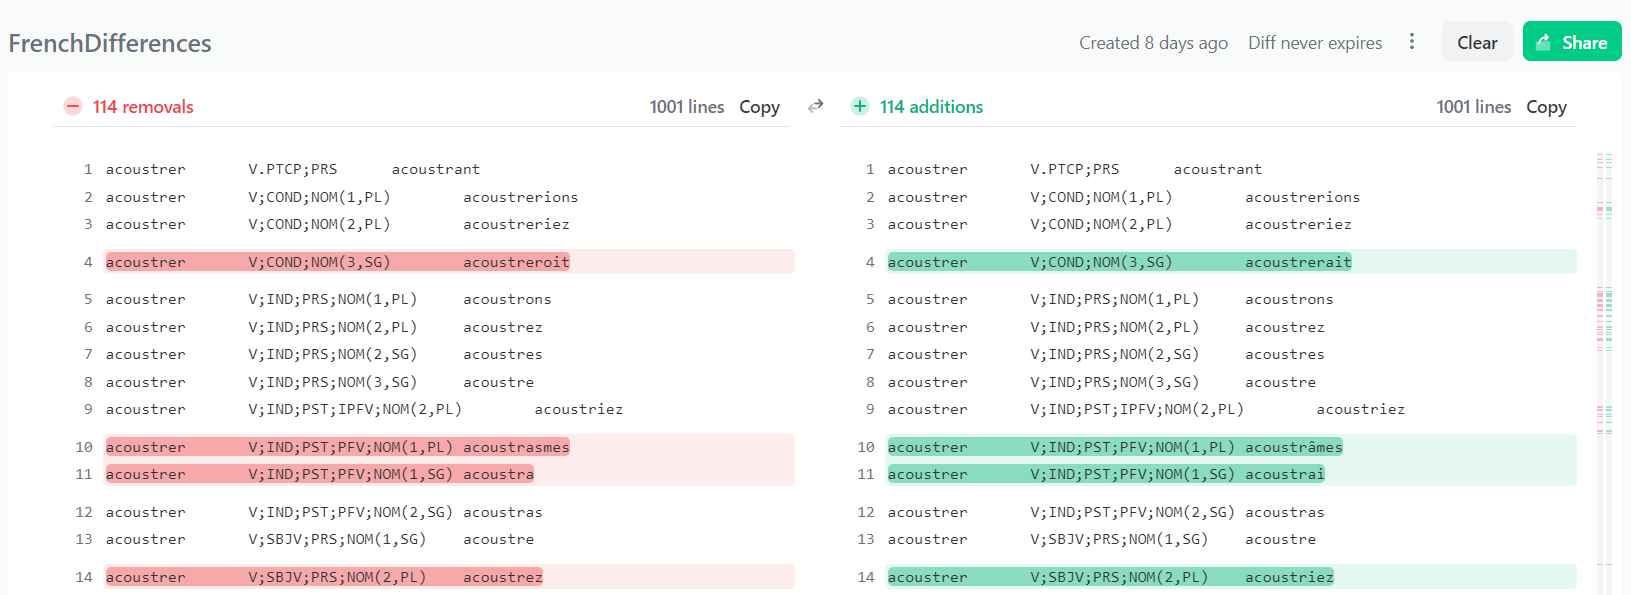
Here you can see the first few differences between fra.dev and what the program generated. We then created a tool that could check through both files and find the words that were causing issues:

In [11]:
#Generate Output file
OLD.main(["Old.py","-o"])

###  Initialize storage for output later  ###

diffLineCounter = 0
problemWords = {}
problemWordErrors = {}

###  Loop through the dev and out files pairwise using zip, finding the problematic words  ###

with open('./data/fra.dev','r') as inFile, open('./Data/fra.out','r') as outFile:
    for inLine, outLine in zip(inFile, outFile):
        if inLine != outLine:
            #Grab the lemma
            inLineSplit = inLine.strip().split("\t")
            curWord = inLineSplit[0]
            diffLineCounter += 1
            if curWord not in problemWords.keys():
                problemWords[curWord] = 1
            else:
                problemWords[curWord] += 1

###  Output the broken words to a text file  ###
                
problemWordsList = sorted(problemWords.items(), key=lambda item: item[1], reverse=True)
with open("./WordsWithIssues.txt",'w') as WordsWithIssues:
    WordsWithIssues.write("Count\tWord\n")
    for x in problemWordsList:
        WordsWithIssues.write("%s\t%s\n" % (x[1],x[0]))

fra: 0.886
Average accuracy 0.886


In [9]:
with open("./WordsWithIssues.txt","r") as file:
    print(file.read())

Count	Word
12	prÃ©lever
11	ouÃ¯r
10	contrepleder
10	reteindre
10	tuner
9	craqueler
7	broicher
6	culcher
6	dÃ©layer
5	acoustrer
5	desregler
5	mendier
4	dÃ©sarmer
4	terser
2	recomparaitre
2	surbooker
2	sÃ©quencer
1	alanguir
1	investir
1	larder
1	objectiver



So now we have a list of words that are giving us trouble. The question now becomes "Why?"

### Finally, some linguistics!

#### Broad overview
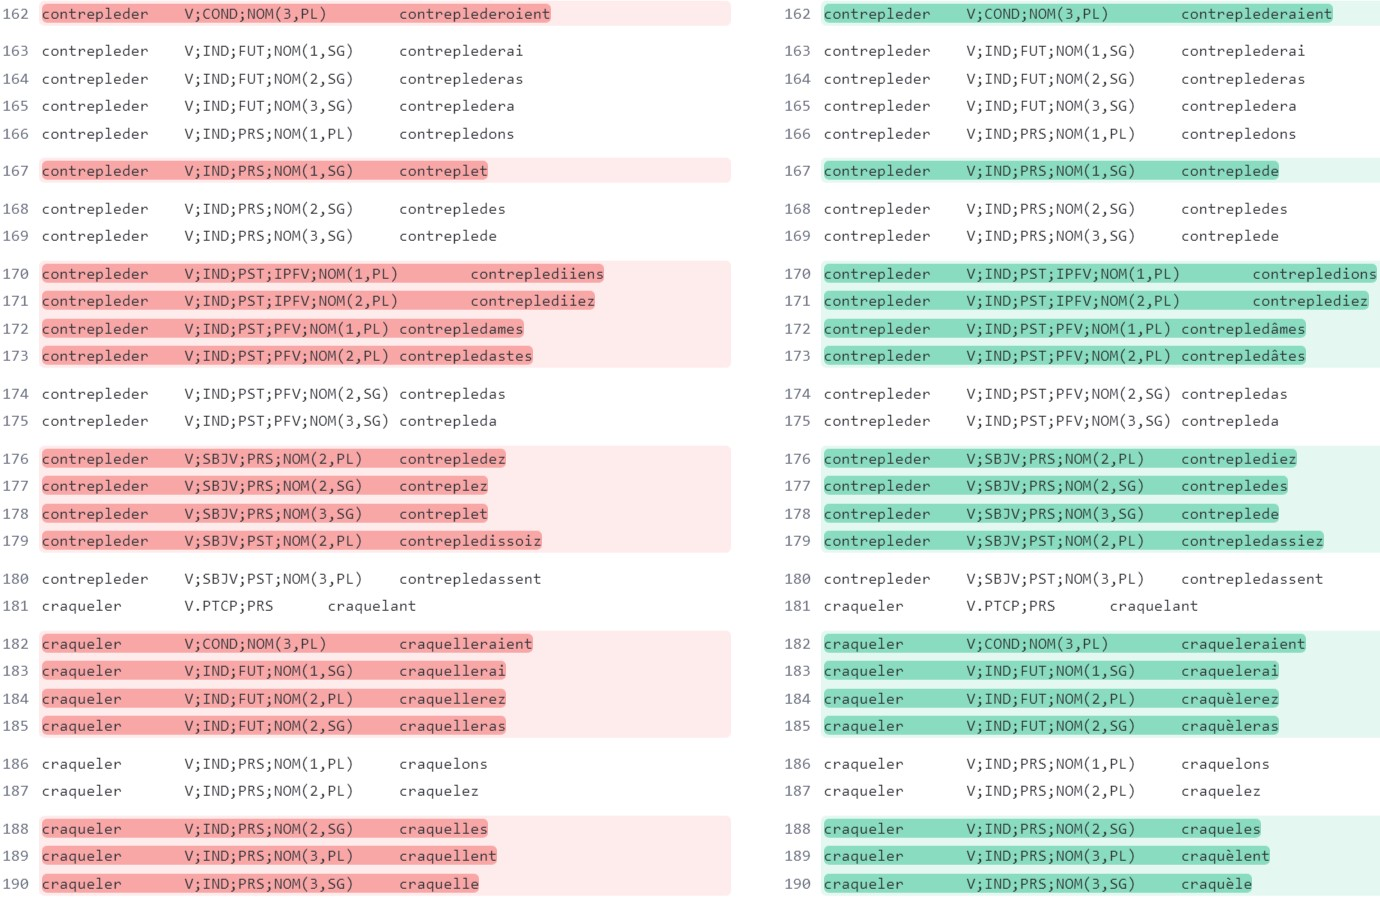
Looking at the data, it seems the most frequently incorrectly conjugated verbs were:
 * Originating from Middle or Old French and thus unpredictably conjugated
 * Modern verbs being conjugated in ways that are either not used in, or optional, in modern French. We suspected this might be the result of its having been trained on data containing old French conjugations.
     * Examples include: âtes instead of asmes, èlerais instead of ellerais
 * Modern verbs where the model was failing to add exceptions like g and o to the beginnings of suffixes

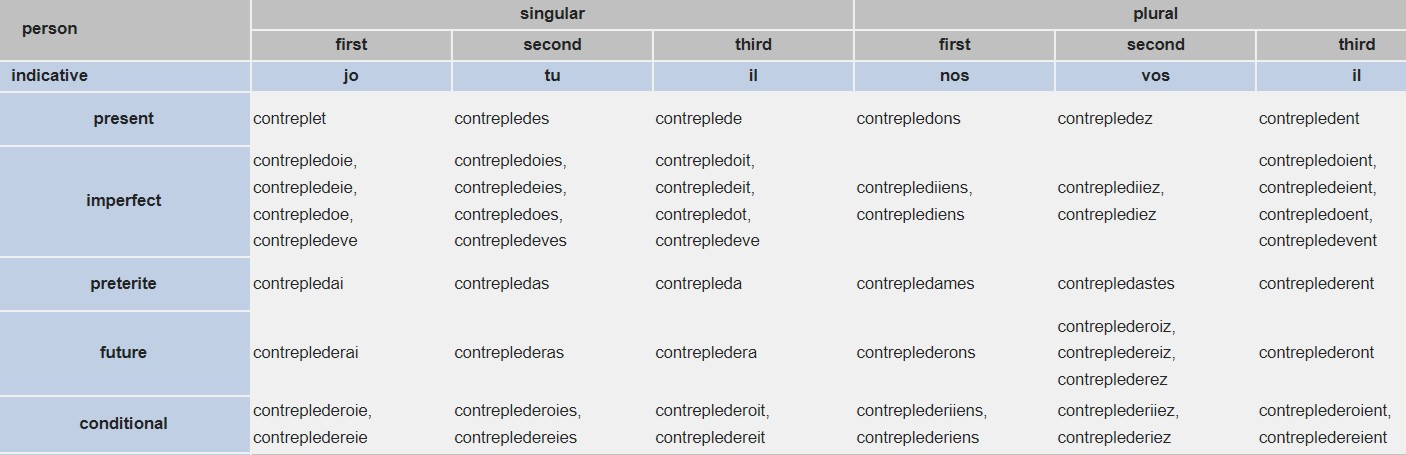
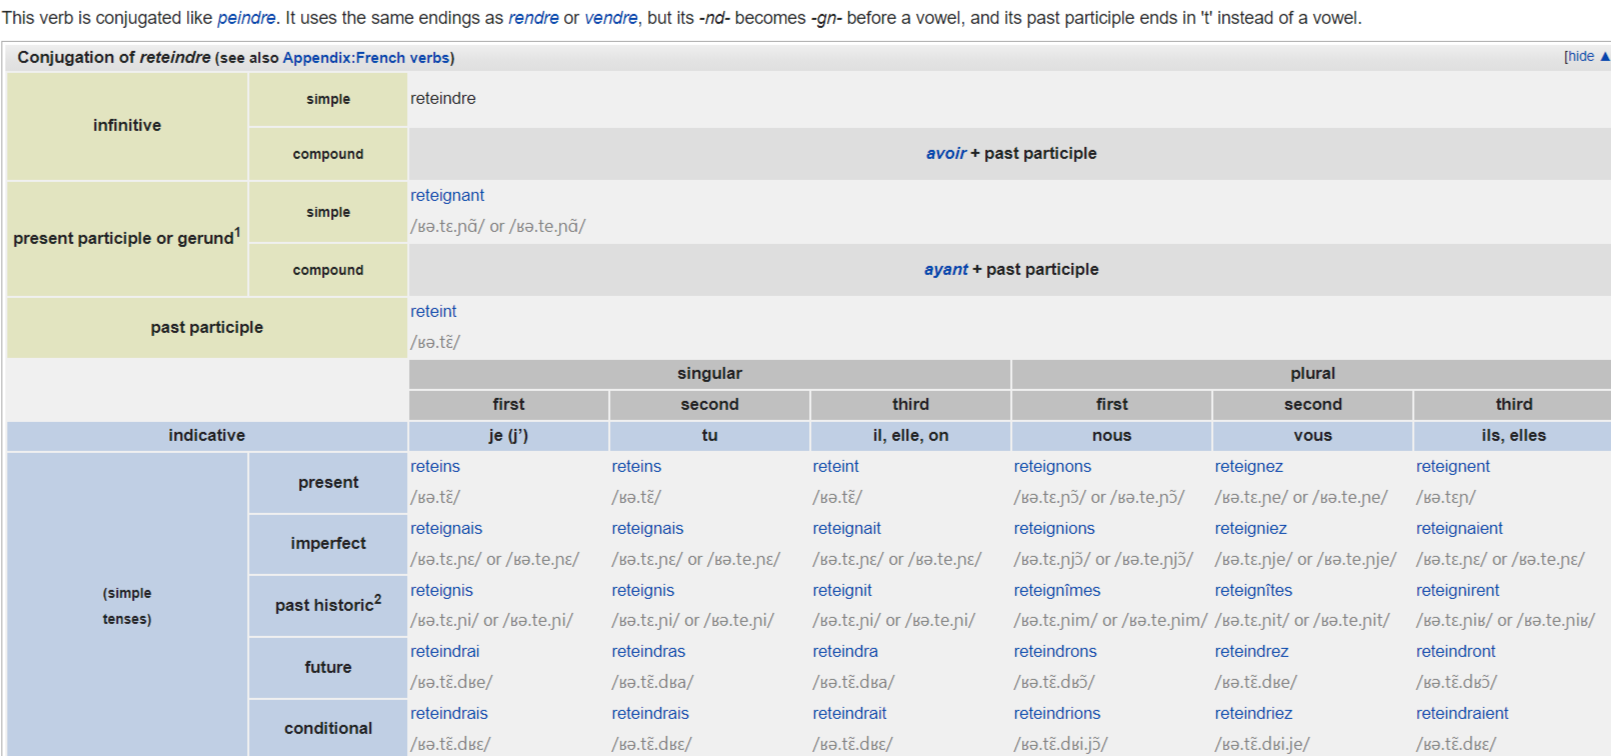
This verb is conjugated like peindre. It uses the same endings as rendre or vendre, but its -nd- becomes -gn- before a vowel, and its past participle ends in 't' instead of a vowel.

#### Damn you, double consonants!
French orthography is often not represented in the phonology (I.E. il, ils, mange, mangent) so at first we did not think it would be productive to follow that line of reasoning when it came to the data. However, when confronted with the èlerais instead of ellerais problem in particular, syllable boundaries became a relevant component of the conjugation.
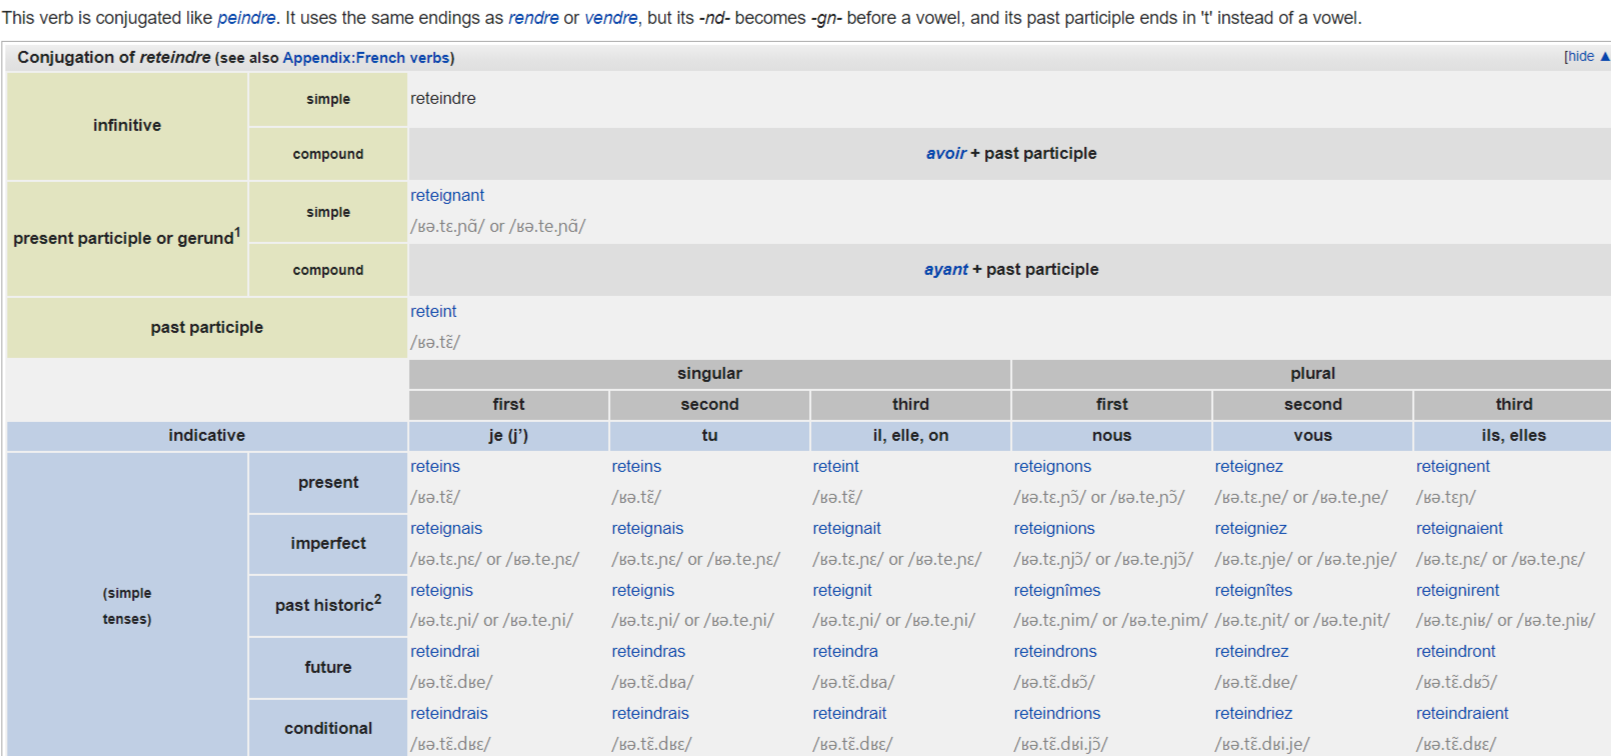
Other than appeler and jeter and their derived verbs, every French verb that doubled the consonants in Middle and Old French can now also be conjugated like amener.

# Step 5: Tools First
We made a tool at this point to help us see what was going on inside this mess of a file. This consisted of making another file `fra.dbg` and a new flag that runs the program only on that file, and prints out some useful info. We added some print statements at certain points like so
```Python
def apply_best_rule(lemma, msd, allprules, allsrules, debug=False):
    if debug: print("Lemma: %s\nFeatures: %s" % (lemma, msd))
    ...
    if applicablerules:
            bestrule = max(applicablerules, key = lambda x: (len(x[0]), x[2], len(x[1])))
            if debug: print("\nApplicable suffix rules:\n%s\nUsing: %s" % (applicablerules, bestrule))
            base = base.replace(bestrule[0], bestrule[1])
```
These are not all the places we added printing but it gives you an idea of how it was implemented.

Then we had to add the option to main the same way we resolved the 'testing doesn't work' issue from before.
```Python
def main(argv):
    options, remainder = getopt.gnu_getopt(argv[1:], 'odthp:', ['output','debug','test','help','path='])
    DEBUG, TEST, OUTPUT, HELP, path = False,False,False, False, './data/'
    ...
    if opt in ('-d', '--debug'):
        DEBUG = True
    ...
    if DEBUG:
        devlines = [line.strip() for line in open(path + lang + ".dbg", "r", encoding='utf8') if line != '\n']
    ...
    outform = apply_best_rule(lemma, msd, allprules, allsrules, DEBUG)
```
Now that we had these tools, we could modify `fra.dbg` with a few words we were struggling against to see what was going wrong.

In [12]:
import DebugModeAdded
DebugModeAdded.main(["DebugModeAdded.py", "-d"])

Lemma: acoustrer
Features: V;COND;NOM(3,SG)

Applicable suffix rules:
[('>', 'it>', 206), ('>', '>', 210), ('>', 'ait>', 154), ('r>', 'rait>', 154), ('>', 't>', 206), ('er>', 'erait>', 144), ('r>', 'roit>', 44), ('er>', 'eroit>', 43), ('>', 'oit>', 44), ('r>', 't>', 4), ('rer>', 'reroit>', 2), ('rer>', 'rerait>', 11)]
Using: ('rer>', 'rerait>', 11)

Applicable prefix rules:
[('<', '<', 209), ('<a', '<a', 19), ('<ac', '<ac', 1), ('<', '<se ', 1)]
Using: ('<', '<', 209)
fra: 0.0
Average accuracy 0.0


As you can see, we now have access to all of the rules it can choose from when trying to modify this form. Unfortunately, it picks the wrong one :/
# Step 6: Try To Fix It
### Pt. 1: The elusive `ll`
We noticed that there was an issue with some words that have `ll` in their spelling but we're being generated with only one `l`. Somebody brought up that this may be related to being at the end of the syllable or possibly silent `e`s. The files we had been given had no syllable markers in their IPA, so we tried to make a syllabifier beceause it couldn't be that hard. (Spoiler alert: It was very hard)

This was our first attempt:
```Python
def syllabifyWord(line, debug=False):
    lineSplit = line.strip().split("\t")
    orthography, ipa = lineSplit[0], lineSplit[1].split(" ")
    spot = len(ipa) - 1
    out = []
    while spot >= 0:
        #CODA
        while ipa[spot] in CONSONANTS and spot > 0:
            out.insert(0,ipa[spot])
            spot -= 1
        #NUCLEUS
        out.insert(0,ipa[spot])
        spot -= 1
        #GLIDE
        if ipa[spot] in 'jɥw':
            out.insert(0,ipa[spot])
            spot -= 1
        #ONSET
        if spot >= 0:
            out.insert(0,ipa[spot])
            spot -= 1
            if ipa[spot+1] in 'lʁ' and ipa[spot] not in 'lʁ' and ipa[spot] in CONSONANTS:
                out.insert(0,ipa[spot])
                spot -= 1
        out.insert(0,'.')
    out.remove('.')
    outString = ''.join(out)
    if debug: print("%-15s  %-15s %-15s" % (orthography,''.join(ipa), outString))
    return outString
```
The idea was to work backwards through the IPA and use phonotactic constraints to insert the boundaries. Unfortunately there are very few resources on French syllable phonotactic constraints with the exception of this paper (Which I spent way to long trying to understand -Sandro)
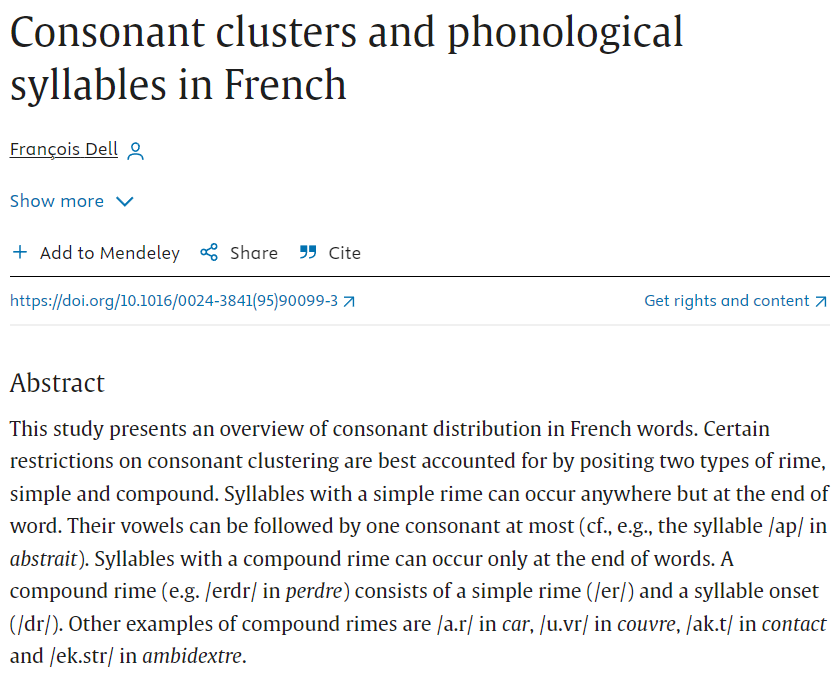

Turns out the rules that people do know are wishy-washy and wonky at best. Sooooooo......

### Pt. 2: Stealing syllable boundaries from Wiktionary
We just scraped it all from the internet because once again French is garbage :)

So now all we had to do was line the IPA sounds up with the spelling and we can figure out when it needs to be `ll` instead of `l`. (Spoiler alert: This didn't work either)

Remember step 1? Well we should have listened and steared clear. There is no way we could have made a program that figures out where a silent `e` is in this amount of time. So anyways, we diverted power to the next idea because this one was about ready to crash and burn.

### Pt 3: What are all these weird verbs doing here?
The data mysteriously included several Old and Middle French verbs. As we mentioned earlier, the conjugations for these verbs varies greatly by region and time period, but there was no clear pattern that distinguished a modern French verb from an Old or Middle French one, so these words were flooding the model with weird suffixing rules that did not apply anywhere else, and were adding to the number of errors when it tried to apply modern French conjugation rules to unfamiliar Old or Middle French ones. We decided to adjust our algorithm to ignore these words, and these changes signficantly improved the accuracy of the model.

#### Pt 3.5: Lam An gets lazy
Initially, as a partial work-around, we decided to ignore any suffixing rules that had only appeared once in the training data (unless it was a rule for the word itself, so the model could still 'cheat' on data it had seen before).

```python
def apply_best_rule(lemma, msd, allprules, allsrules, debug=False, no_pref=False, subset=None, wordmap=None):
    ...
    if msd in allsrules:
        # One applicable rule is a 3-tuple containing the input, output, and frequency
        applicablerules = [(x[0],x[1],y) for x,y in allsrules[msd].items() if x[0] in base and (x[0]==base[1:] or y > 1)]
    ...
```

In [3]:
print('Dev accuracy:')
nnfuncs['main']['pre_csv'](['pre_csv'])
print('Test accuracy:')
nnfuncs['main']['pre_csv'](['pre_csv', '-t'])

Dev accuracy:
fra: 0.892
Average accuracy 0.892
Test accuracy:
fra: 0.798
Average accuracy 0.798


### Pt 4: What if we are smarter about the stupid words?
~~Four cups of coffee later, Lam An was feeling somewhat less lazy,~~ We later decided to completely filter out the Old and Middle French verbs using a quick bash script and a couple simple regular expressions... (see an excerpt below)

```bash
...
cut -f 1 $1 | sort | uniq | while read -r line ; do
    curl -s "$base_url$line" > tmp
    grep -e '<span class=\"mw-headline[^>]*>[^<]*<' tmp | sed -r 's;.*<span class=\"mw-headline[^>]*>([^<]*)<.*;\1;g' > tmp2
    if [[ $(grep '^French' tmp2) ]] ; then
        if [[ $(ggrep -P '<span class=\"usage-label-sense((?<!<a).)*<a[^>]*>dated<' tmp) ]] ; then
            echo "$line,dtd" >> "tmp-marked.csv"
        elif [[ $(grep 'Category:French obsolete forms' tmp) ]] ; then
            echo "$line,obs" >> "tmp-marked.csv"
        else
            echo "$line,-" >> "tmp-marked.csv"
        fi
    else
        if [[ $(grep 'Middle French' tmp2) ]] && [[ $(grep 'Old French' tmp2) ]] ; then
            echo "$line,M-O" >> "tmp-marked.csv"
        elif [[ $(grep 'Middle French' tmp2) ]] ; then
            echo "$line,M" >> "tmp-marked.csv"
        else
            echo "$line,O" >> "tmp-marked.csv"
        fi
    fi
done
...
```

The above bash script downloads the wiktionary page for a given lemma, then uses regular expressions to find out whether the word is regular modern French, dated, obsolete, Middle, or Old. It outputs all of this to a csv file (Lam An got lazy again and could not figure out why it was refusing to output tab characters), which we can then use to look up whether a given word is modern French or not.

```
...
apareillier,O
aparir,O
apothéoser,-
approcher,-
approximer,-
arrimer,-
assassiner,-
aterminer,M
aymer,M+O
badigeonner,-
balocher,-
barouder,-
bavarder,-
becquer,-
bedonner,-
beigner,-
benzoyler,-
berner,-
...
```

We then created some functions to use these csv files in nonneural.py. First, we had to be able to use the information from the CSV files in our code.

```python
def load_word_map():
    # programmatically generate list of CSVs
    files = [ 'marked-fra.{}.csv'.format(x) for x in ('dev', 'trn', 'tst') ]

    wordmap = {} # Initialize empty dictionary
    for f in files: # Loop through all the files
        try:
            with open(os.path.join('data', f)) as mapfile:
                for line in mapfile:
                    if line.strip() != '': # Lines are all <word>,<category>
                        word, fam = line.strip().split(',')
                        wordmap[word] = fam # Dictionary maps words to their categories
        except FileNotFoundError: # Handle error if one of the files does not exist
            print('File {} not yet generated.'.format(f))
    
    return wordmap
```

Then, we had to be able to check whether a given word belonged to one of several pre-defined subsets.

```python
def is_in_subset(lemma, subset, wordmap):
    subset_opts_map = {             # Use dictionary to define which categories are included
        'mod': ['-', 'dtd', 'obs'], # in which subsets
        'no_old': ['-', 'dtd', 'obs', 'M'],
        'no_dtd': ['-', 'obs'],
        'no_obs': ['-', 'dtd'],
        'mod_strict': ['-']
    }

    if subset is None: # If there was no subset argument, the 'subset' is the full data set
        return True
    
    if '.' in subset: # Include option to run on certain prefixes or suffixes
        fix, substr = subset.split('.', maxsplit=1)
        if fix == 'pre':
            return lemma[:len(substr)] == substr
        if fix == 'suf':
            return lemma[-len(substr):] == substr
        warn('{} is not a valid affix type. Running script on unfiltered data set.'.format(fix))
        return True
    
    if subset in subset_opts_map.keys():
        return wordmap[lemma] in subset_opts_map[subset]
    
    warn('Invalid argument passed to --subset option. Running script on unfiltered data set.')
    return True # Run as though no subset was passed if the subset arg invalid
```

After this, we still had to update our other functions to exclude words from certain subsets when necessary:

```python
def apply_best_rule(lemma, msd, allprules, allsrules, debug=False, no_pref=False, subset=None, wordmap=None):
    ...
    if not subset is None and not is_in_subset(lemma, subset, wordmap):
        return
    ...
```

Finally, we updated our `main` function:

```python
def main(argv):
    options, remainder = getopt.gnu_getopt(argv[1:], 'odSs:g:thp:', ['output','debug','suffix-only','subset=','ignore=','test','help','path='])
    DEBUG, NO_PREF, SUBSET, IGNORE, TEST, OUTPUT, HELP, path = False,False,None,None,False,False, False, './Data/'
    ...
    for lang in [os.path.splitext(d)[0] for d in os.listdir(path) if '.trn' in d]:
        ...
        for l in lines: # Read in lines and extract transformation rules from pairs
            lemma, msd, form = l.split(u'\t')

            if IGNORE not in ('trn', 'all') or is_in_subset(lemma, SUBSET, wordmap):
                if prefbias > suffbias:
                    lemma = lemma[::-1]
                    form = form[::-1]
                prules, srules = prefix_suffix_rules_get(lemma, form)
                ...
        
        devlines = [line.strip() for line in open(path + lang + ".dev", "r", encoding='utf8') if line != '\n']
        ...
        for l in devlines:
            lemma, msd, correct = l.split(u'\t')
#                    lemma, msd, = l.split(u'\t')
            if prefbias > suffbias:
                lemma = lemma[::-1]
            if IGNORE in ('tst', 'all'):
                outform = apply_best_rule(lemma, msd, allprules, allsrules,
                                          debug=DEBUG,
                                          no_pref=NO_PREF,
                                          subset=SUBSET,
                                          wordmap=wordmap)
            else:
                outform = apply_best_rule(lemma, msd, allprules, allsrules, debug=DEBUG)
        ...
```

In [11]:
print('Dev accuracy:')
nnfuncs['main']['filter_old'](['filter_old', '--subset=mod', '--ignore=all'])
print('Test accuracy:')
nnfuncs['main']['filter_old'](['filter_old', '--test', '--subset=mod', '--ignore=all'])

Dev accuracy:
fra: 0.94222
Average accuracy 0.9422222222222222
Test accuracy:
fra: 0.86707
Average accuracy 0.8670731707317073


### Pt 5: -eCer and -éCer verbs

Remember the issue with l'accent grave? Well we remembered that this stem change is one often seen in certain conjugations of verbs that end in -eCer or -éCer, but the code is only checking for exact matches on suffixes, general patterns of consonants and vowels. We adjusted the code to account for the broader pattern, and saw another (modest) boost in accuracy.

We could have just manually inserted these rules into `allsrules`, but ~~Lam An didn't want to~~ that would have been a bit time consuming and would have required figuring out what frequency to give them so they were applied in the correct situations. In the end, we altered the `prefix_suffix_rules_get` function instead:

```python
def prefix_suffix_rules_get(lemma, form):
    ...
    lp,lr,ls,fp,fr,fs = alignprs(lemma, form) # Get six parts, three for in three for out

    # Suffix rules
    ins  = lr + ls + ">"
    outs = fr + fs + ">"

    srules = set()
    for i in range(min(len(ins), len(outs))):
        clean = ins[i:].replace('_', '')
        if len(clean) == 5 and clean[-3:] == 'er>' and clean[-5] in 'eé' and clean[-4] not in 'aâeéèêiïîoôuû':
            srules.add((clean[:-4]+'C'+clean[-3:], replace_first_inst(outs[i:],clean[-4],'C')))
        ...
```

Note: `replace_first_inst` is another function we defined ourselves since we (*cough* Lam An *cough*) were too lazy to find a builtin function that did this, although it probably exists somewhere.

This also required a slight update to our `apply_best_rule` function:

```python
def apply_best_rule(lemma, msd, allprules, allsrules, debug=False, no_pref=False, subset=None, wordmap=None):
    ...
    if msd in allsrules:
        # One applicable rule is a 3-tuple containing the input, output, and frequency
        applicablerules = [(x[0],x[1],y) for x,y in allsrules[msd].items() if x[0] in base and (x[0]==base[1:] or y > 1)]
        if base[-4] not in 'aâeéèêiïîoôuû':
            for x,y in allsrules[msd].items():
                if len(x[0]) == 5 and x[0] == base[-5] + 'C' + base[-3:]:
                    applicablerules.append((x[0].replace('C',base[-4]), x[1].replace('C',base[-4]), y))
        ...
```

In [12]:
print('Dev accuracy:')
nnfuncs['main']['ecer'](['ecer', '--subset=mod', '--ignore=all'])
print('Test accuracy:')
nnfuncs['main']['ecer'](['ecer', '--test', '--subset=mod', '--ignore=all'])

Dev accuracy:
fra: 0.95
Average accuracy 0.95
Test accuracy:
fra: 0.88414
Average accuracy 0.8841463414634146


### Pt 6: Maybe it's smart enough now

After all this, we noticed it was still struggling with a number of (modern) irregular verbs. Many of these verbs belong to groups, where a number of verbs are derived from the same irregular root and are all conjugated in the same irregular way. This was initially assumed to be an issue within the training data, but upon further investigation, we realized the control for low-frequency rules was actually impeding more than it was helping, since if there were irregular verbs from the same group in the training data, the model would not apply them if they had only seen them once.

In [14]:
print('Dev accuracy:')
nnfuncs['main']['final'](['final', '--x-set=mod', '--y-set=mod'])
print('Test accuracy:')
nnfuncs['main']['final'](['final', '--test', '--x-set=mod', '--y-set=mod'])

Dev accuracy:
fra: 0.96
Average accuracy 0.96
Test accuracy:
fra: 0.91463
Average accuracy 0.9146341463414634


# Step 7: Make an Interactive Notebook

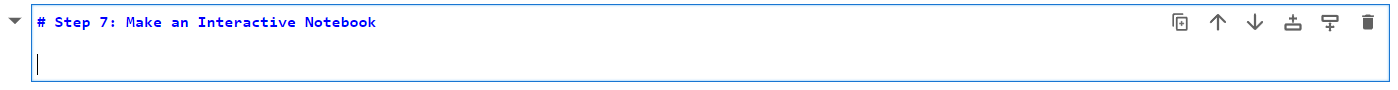

In our notebook we'll need our data well organized:
|Version|`fra.dev`|`fra.tst`|
|---|---|---|
|OLD|88.6%|---|
|OldButTestingWorks|88.6%|77.7%|
|IgnoreInfrequentRules|89.2%|79.8%|
|IgnoreOldFrenchToo|94.2%|86.7%|
|e/éCerPattern|95.0%|88.4%|
|Final|96.0%|91.5%|

# Potential Future Changes

### Other ways to abstract patterns
The eCer/éCer verbs highlight an interesting potential overall issue with the code, which is that it looks for exact matches in suffixes/prefixes, and cannot account for a more abstract pattern (such as one that only cares whether there is a vowel/consonant in a certain position). It would be interesting to try and identify other helpful ways to abstract the rule set, or if the algorithm could be altered to include multiple kinds of rules (some more specific, some broader), and then apply a different method for selecting the best rule.

### ~~Cheating~~ Adding more irregular verbs to the training data
As mentioned earlier, while there are many irregular French verbs, they all generally belong to groups of irregular verbs that are all conjugated the same way. Adding more of these to the training data would likely help the model with conjugating a wider variety of irregular verbs.

### Revisiting grapheme to morpheme conversion
Originally, the grapheme to morpheme conversion process seemed too daunting to try and tackle, but we have since discovered the benefit of stealing from wiktionary/wikipron. We did start the process of scraping wiktionary for IPA transcriptions of all the data, (even more regular expressions, hooray!)
```bash
...
while read -r line ; do
    lemma=$(echo "$line" | cut -f 1)
    if [ "$lemma" != "$lastword" ] ; then
        curl "$baseurl$lemma" > wikt.html
    fi
    lemma_ipa=$(grep ">IPA<.*French pronunciation.*<span class=\"IPA\">[^>]*" wikt.html | sed -r "s/.*<span class=\"IPA\">([^<]*).*/\1/g")

    msd=$(echo "$line" | cut -f 2)
    form=$(echo "$line" | cut -f 3)
    form_ipa=$(grep ">$form<.*<span class=\"IPA\">[^<]*" wikt.html | sed -r "s/.*>$form<.*<span class=\"IPA\">([^<]*)<.*/\1/g")
    if [ "$lemma" == "$form" ] ; then
        form_ipa="$lemma_ipa"
    fi
    if [[ -z $lemma_ipa ]] ; then
        lemma_ipa="NONE"
    fi
    if [[ -z $form_ipa ]] ; then
        form_ipa="NONE"
    fi
    form_ipa=$(echo $form_ipa | cut -w -f 1)
    echo -e "$lemma\t$lemma_ipa\t$msd\t$form\t$form_ipa" >> "$ipafile"
    lastword=$lemma
done < "$infile"
...
```
but there are some words for which wiktionary has audio files and no IPA,
```
insurger	NONE	V.CVB;PRS	en insurgeant	NONE
insurger	NONE	V;COND;NOM(1,SG)	insurgerais	/ɛ̃.syʁ.ʒə.ʁɛ/
insurger	NONE	V;COND;NOM(2,SG)	insurgerais	/ɛ̃.syʁ.ʒə.ʁɛ/
insurger	NONE	V;COND;NOM(3,SG)	insurgerait	/ɛ̃.syʁ.ʒə.ʁɛ/
insurger	NONE	V;IND;FUT;NOM(1,SG)	insurgerai	/ɛ̃.syʁ.ʒə.ʁe/
insurger	NONE	V;IND;FUT;NOM(2,PL)	insurgerez	/ɛ̃.syʁ.ʒə.ʁe/
insurger	NONE	V;IND;FUT;NOM(2,SG)	insurgeras	/ɛ̃.syʁ.ʒə.ʁa/
insurger	NONE	V;IND;FUT;NOM(3,PL)	insurgeront	/ɛ̃.syʁ.ʒə.ʁɔ̃/
insurger	NONE	V;IND;FUT;NOM(3,SG)	insurgera	/ɛ̃.syʁ.ʒə.ʁa/
insurger	NONE	V;IND;PRS;NOM(1,PL)	insurgeons	/ɛ̃.syʁ.ʒɔ̃/
insurger	NONE	V;IND;PRS;NOM(2,SG)	insurges	/ɛ̃.syʁʒ/
```
and others for which the data is using a modern French verb inherited from Middle French and for some reason also insisting on Middle French conjugation rules.
```
hucher	/y.ʃe/	V;IND;PRS;NOM(1,PL)	huchons	/y.ʃɔ̃/
hucher	/y.ʃe/	V;IND;PRS;NOM(3,PL)	huchent	/yʃ/
hucher	/y.ʃe/	V;IND;PRS;NOM(3,SG)	huche	/yʃ/
hucher	/y.ʃe/	V;IND;PST;IPFV;NOM(1,PL)	huchions	/y.ʃjɔ̃/
hucher	/y.ʃe/	V;IND;PST;IPFV;NOM(2,PL)	huchiez	/y.ʃje/
hucher	/y.ʃe/	V;IND;PST;IPFV;NOM(2,SG)	huchois	NONE
hucher	/y.ʃe/	V;IND;PST;IPFV;NOM(3,PL)	huchoient	NONE
hucher	/y.ʃe/	V;IND;PST;IPFV;NOM(3,SG)	huchoit	NONE
hucher	/y.ʃe/	V;IND;PST;PFV;NOM(1,PL)	huchasmes	NONE
hucher	/y.ʃe/	V;IND;PST;PFV;NOM(3,SG)	hucha	/y.ʃa/
hucher	/y.ʃe/	V;NFIN	hucher	/y.ʃe/
hucher	/y.ʃe/	V;POS;IMP;NOM(1,PL)	huchons	/y.ʃɔ̃/
hucher	/y.ʃe/	V;SBJV;PRS;NOM(1,PL)	huchons	/y.ʃɔ̃/
hucher	/y.ʃe/	V;SBJV;PRS;NOM(2,PL)	huchez	/y.ʃe/
hucher	/y.ʃe/	V;SBJV;PRS;NOM(3,PL)	huchent	/yʃ/
```
~~You may have noticed that the tab character is mysteriously functioning now~~ Any attempt at running this algorithm on phonetic transcriptions would first require a lot of data clean-up.

Beyond that, there are some questions as to how one would handle various aspects of the IPA. Should syllable boundaries be included? Should we treat nasal vowels as one symbol or two (orthographically, they would generally be represented by a following m or n, plus the current algorithm slightly penalizes substitution compared to insertion and deletion)? These would be interesting problems to explore in the future.

### More data cleanup
Aside from the Old/Middle/obsolete/dated issues, the training data includes several entries (that we've noticed so far) that a model for morphological inflection simply will not be able to account for.

For example, the verb *infiltrer* must take a reflexive pronoun, so the lemma is still listed as *infiltrer* but the conjugated forms all include the additional reflexive pronouns (which are also spelled wrong). There are no orthographic or phonemic indicators for whether or not a verb requires a reflexive pronoun, so it is unclear why one would try to train the model this way.

Additionally, as mentioned earlier, some verbs have multiple "correct" options for a given inflected form, but the training, test, and dev data only allow for one. It would be good to alter the data and possibly the algorithm to account for these facts, but it also may turn out that given establishing and revising of rules by l'Académie Française, French linguistic data may be better collected through different means.